In [2]:
import matplotlib as mpl
# mpl.use("pgf")
%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
import time

import numpy as np
import scipy as sp
from sklearn import decomposition
from sklearn.linear_model import LinearRegression
from functools import partial

Let's load the packages

In [22]:
import torch
import vjf
from vjf import online

We have synthesized some data from Lorenz attractor, 3D state, 200D observation, 216 realizations, each lasts 1500 steps. Let's load the data first. ([download here](https://doi.org/10.6084/m9.figshare.14588469))

In [24]:
data = np.load('lorenz_216_1500_10_200_gaussian_s0.npz')

KeysView(<numpy.lib.npyio.NpzFile object at 0x7f94bd9f1470>)

In [35]:
xs = data['x']  # state
ys = data['y']  # observation
us = data['u']  # control input
xdim = xs.shape[-1]
ydim = ys.shape[-1]
udim = us.shape[-1]

Firstly we draw some of the latent trajectories.

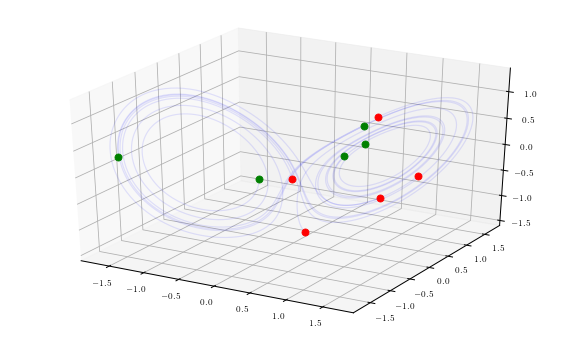

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.set_aspect('equal')
for x in xs[::50, ...]:
    ax.plot(*x.T, color='b', alpha=0.1, zorder=1)
    ax.scatter(*x[0, :], color='g', s=50, zorder=2)
    ax.scatter(*x[-1, :], color='r', s=50, zorder=2)
# plt.axis('off')
plt.show()
plt.close()

One can see the two wings. The green/red dots are the initial/final states.

Secondly we draw one series of observation.

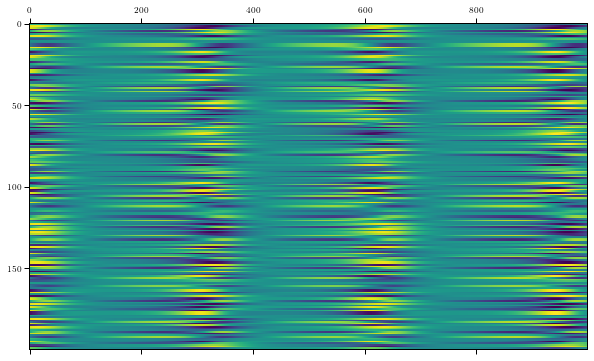

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.matshow(ys[0, :, :].T, aspect='auto')
# plt.axis('off')
plt.show()
plt.close()

Now we fit the model.

In [42]:
likelihood = 'gaussian'  # Gaussain observation. 'poisson' also available
dynamics = 'rbf'  # RBF network dynamic model
recognizer = "mlp"  # MLP recognitiom model
rdim = 50  # number of RBFs
hdim = 100  # number of MLP hidden units

mdl = online.VJF(
    config=dict(
        resume=False,
        xdim=xdim,  # latent dimension
        ydim=ydim,  # observation dimension
        udim=udim,  # control input dimension
        Ydim=udim,
        Udim=udim,
        rdim=rdim,  # number of RBFs for RBF network
        hdim=hdim,  # numerb of hidden units of MLP
        lr=1e-3,  # learning rate
        clip_gradients=5.0,  # maximum grad value
        likelihood=likelihood,  # likelihood
        system=dynamics,  # state dynamics
        recognizer=recognizer,  # encoder
        C=(None, True),  # loading matrix: (initial value, trainable)
        b=(None, True),  # bias: (initial value, trainable)
        Q=(1.0, True),  # state noise (initial value, trainable)
        R=(1.0, True),  # observation noise (initial value, trainable), only for gaussian
    )
)    

{'A': (None, False),
 'B': (array([[0.],
       [0.],
       [0.]]), False),
 'C': (None, True),
 'Q': (1.0, True),
 'R': (1.0, True),
 'Udim': 1,
 'Ydim': 1,
 'activation': 'tanh',
 'b': (None, True),
 'batch_norm': False,
 'clip_gradients': 5.0,
 'debug': True,
 'hdim': 100,
 'likelihood': 'gaussian',
 'lr': 0.001,
 'optimizer': 'adam',
 'path': '/home/yuan/vrdf_torch/notebook',
 'random_seed': None,
 'rdim': 50,
 'recognizer': 'mlp',
 'resume': False,
 'system': 'rbf',
 'udim': 1,
 'xdim': 3,
 'ydim': 200}
Gaussian likelihood


In [43]:
# We feed the data multiple times to help the training
# This may take some time
n_epoch = 10

for i in range(n_epoch):
    mu, logvar, losses = mdl.filter(ys, us)

# you can also use mdl.fit which is a wrapper of above block
# mu, logvar, loss = mdl.fit(ys, us, max_iter=50)  # posterior mean, variance and loss (negative ELBO)

mu = torch.detach(mu).numpy().squeeze()  # convert to numpy array


Then we draw the estimated states. You can see the manifold. Note that the states are subject to an arbitrary affine transformation.

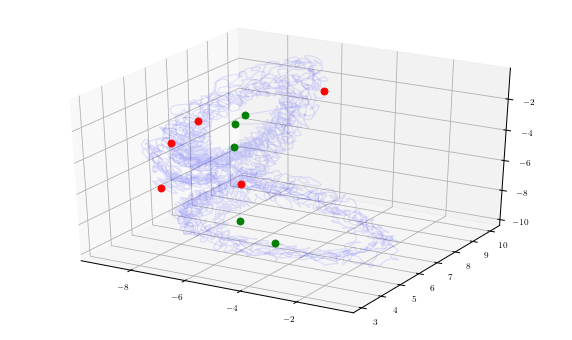

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.set_aspect('equal')
for x in mu[::50, ...]:
    ax.plot(*x.T, color='b', alpha=0.1, zorder=1)
    ax.scatter(*x[0, :], color='g', s=50, zorder=2)
    ax.scatter(*x[-1, :], color='r', s=50, zorder=2)
# plt.axis('off')
plt.show()
plt.close()

Sample future trajectory

In [ ]:
# you can sample multistep trajectories given initial state
x_future, y_future = mdl.forecast(x0=torch.zeros(5, 3), step=10)
print(x_future.shape, y_future.shape)
